In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbimporter
import mainstream_tests
from matplotlib import rc
rc('text', usetex=True)

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("ticks")

In [2]:
def get_songs_data(cleaned_data, recommended=True, obs_threshold=7, separate_rec=True):
    """
    Gets the number of songs and plays for each user (calculates S/P diversity index)
    :param obs_threshold: user must have this number of observations of more to be kept in the dataset
    :param cleaned_data: data after removing outliers
    :param recommended: gets the recommended part of the dataset if True, the organic part otherwise
    :return: a pandas Series with [user_id, S/P] as its rows
    """
    if separate_rec:
        # Separating based on entry's origin -- should use map function if refactoring ever occurs
        if recommended:
            songs_data = cleaned_data[cleaned_data["origin"].str.contains("flow|reco")]
        else:
            songs_data = cleaned_data[~cleaned_data["origin"].str.contains("flow|reco")]
    else:
        songs_data = cleaned_data
    
    # Computing for each user every S and their respective P
    songs_data = songs_data.groupby(["user_id", "sng_id"]).size()

    # Determine and drop cases with too few observations (see obs_threshold)
    thresh_tester = songs_data.sum(level="user_id")
    thresh_tester = thresh_tester[thresh_tester < obs_threshold]
    songs_data.drop(thresh_tester.index.values, inplace=True)

    # No exception will be raised even on empty series (in case no value is above obs-threshold)
    songs_data = songs_data.groupby(["user_id"]).size().divide(songs_data.sum(level="user_id"))
    return songs_data

In [3]:
FILE_NAME = "../../data/artist_streams.csv"

MIN_REC = 17
MIN_ORG = 83

print("Reading data...")
data = pd.read_csv(FILE_NAME)
data

Reading data...


,user_id,ts,sng_id,album_id,listening_time,listen_type,origin,art_id
0,53a2a460127df49eef5976193c14728c695c3463,1471344689,121710324,12721422,203,MOD,page_playlist,249599
1,d81f8a1d9fd30af3c189fbe99c26fd6d4db11375,1471364400,121710324,12721422,1,MOD,page_playlist,249599
2,b26ce863e9161cc7e36cdf254927457cc5ceb55b,1471320765,121710324,12721422,203,MOD,page_playlist,249599
3,206929899c1bfc3c49174d20824ab1dc77758567,1471355821,121710324,12721422,115,smartradio,flow,249599
4,111f74340b5ef733f7dc99dc5494de3da4dbeea7,1471336531,121710324,12721422,203,smartradio,flow,249599
...,...,...,...,...,...,...,...,...
2242112,bb2a3a806a8d9ae05bc63fa2182a3fb645530a49,1471505913,117303310,12174146,14,MOD,page_album,1197905
2242113,92ff662b58d3bd81e5cdc06a6438ad4bf490d938,1471983156,9900601,907173,18,MOD,page_album,1182806
2242114,92ff662b58d3bd81e5cdc06a6438ad4bf490d938,1471982447,9900591,907173,9,MOD,page_album,1182806
2242115,92ff662b58d3bd81e5cdc06a6438ad4bf490d938,1471982430,9900589,907173,8,MOD,page_album,1182806


In [4]:
data = mainstream_tests.clean_data(data)
data

Computing z-score...
Cleaning...


,user_id,ts,sng_id,album_id,listening_time,listen_type,origin,art_id
0,53a2a460127df49eef5976193c14728c695c3463,1471344689,121710324,12721422,203,MOD,page_playlist,249599
2,b26ce863e9161cc7e36cdf254927457cc5ceb55b,1471320765,121710324,12721422,203,MOD,page_playlist,249599
3,206929899c1bfc3c49174d20824ab1dc77758567,1471355821,121710324,12721422,115,smartradio,flow,249599
4,111f74340b5ef733f7dc99dc5494de3da4dbeea7,1471336531,121710324,12721422,203,smartradio,flow,249599
5,5f935bea161673f83b0645325bc3da5d113b7f91,1471353443,121710324,12721422,203,MOD,page_playlist,249599
...,...,...,...,...,...,...,...,...
2242099,b3007b94f1a0eb95c508d4fea8320b862ce29a7b,1473194917,93916044,9543328,44,MOD,page_album,308253
2242104,2ad14bc4eb38a15310b0b00b87494a67ed47100d,1475437996,113798794,11786202,73,MOD,page_artist,4312845
2242106,2130c0788bffdf1acc303448c710cee67fc1a629,1476980760,75644372,7492179,84,MOD,page_album,417037
2242110,a351ff8a54dcb58cfa06de787d010220a9565fa2,1471467359,13157903,1207138,44,MOD,page_artist,2380


## Po/Pr

In [5]:
data["reco"] = data["origin"].map(mainstream_tests.is_reco)
rec_org_plays = data.groupby(["user_id", "reco"]).size().to_frame().reset_index()
rec_org_plays = rec_org_plays[rec_org_plays["reco"] == False].merge(rec_org_plays[rec_org_plays["reco"] == True], on="user_id").drop(["reco_x", "reco_y"], axis=1)
rec_org_plays.columns = ["user_id", "Po", "Pr"]
rec_org_plays

<ipython-input-5-89b9e03d6267>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["reco"] = data["origin"].map(mainstream_tests.is_reco)


,user_id,Po,Pr
0,00877d231a1d10859eefd4288ecc493fd1ea3589,2256,1896
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,2052,450
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,1288,5
3,0282983996af7f6b2a27cfff67fc8982619561d6,1454,309
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,1016,133
...,...,...,...
939,fe016f7c946213bd53ca9b683b7314d24d2dbba9,618,36
940,fe22a3978a595c3a63cb40558db7804956f8e1d7,440,8
941,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,738,5
942,fea927761d221701b2bf1b6acc2de6d91d060071,2800,12


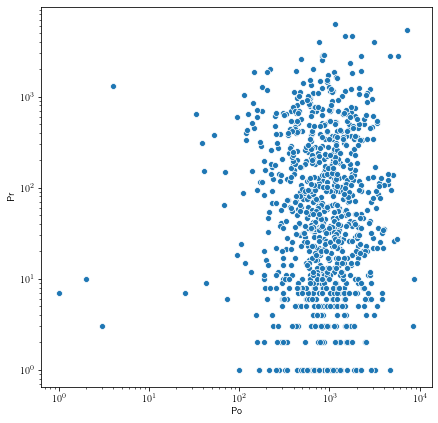

In [7]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x="Po", y="Pr", data=rec_org_plays)
plt.savefig("../../results/plays_rec_org_loglog.pdf")

## So/Po vs Sr/Pr

In [6]:
print("Computing diversity ratio...")
rec_data = get_songs_data(data, recommended=True, obs_threshold=0)
org_data = get_songs_data(data, recommended=False, obs_threshold=0)

print("Organizing data...")
# get_songs_data produces a pd.Series, which we turn into a DataFrame before adjusting some column names
org_data = org_data.to_frame()
rec_data = rec_data.to_frame()
org_data.index.names = ["user"]
rec_data.index.names = ["user"]
org_data.columns = ["ratio"]
rec_data.columns = ["ratio"]
org_data["recommended"] = 0
rec_data["recommended"] = 1
org_data = pd.concat([org_data, rec_data])
org_data = org_data.reset_index()

org_data

Computing diversity ratio...
Organizing data...


,user,ratio,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272516,0
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.386520,0
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512795,0
...,...,...,...
1961,fe016f7c946213bd53ca9b683b7314d24d2dbba9,1.000000,1
1962,fe22a3978a595c3a63cb40558db7804956f8e1d7,1.000000,1
1963,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,1.000000,1
1964,fea927761d221701b2bf1b6acc2de6d91d060071,1.000000,1


In [7]:
# Remove singletons
org_data = org_data[org_data.groupby("user").user.transform(len) > 1]
org_data

,user,ratio,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272516,0
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.386520,0
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512795,0
...,...,...,...
1961,fe016f7c946213bd53ca9b683b7314d24d2dbba9,1.000000,1
1962,fe22a3978a595c3a63cb40558db7804956f8e1d7,1.000000,1
1963,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,1.000000,1
1964,fea927761d221701b2bf1b6acc2de6d91d060071,1.000000,1


In [8]:
# Adding user bins
u_bins = pd.read_csv("../../data/user_bins.csv")
u_bins.columns = ["user", "rate", "plays", "u_bin_nb"]
org_data = org_data.merge(u_bins, on="user")
org_data

,user,ratio,recommended,rate,plays,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0,0.456532,4164,4
1,00877d231a1d10859eefd4288ecc493fd1ea3589,0.375527,1,0.456532,4164,4
2,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0,0.179395,2514,3
3,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.531111,1,0.179395,2514,3
4,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272516,0,0.003861,1295,1
...,...,...,...,...,...,...
1871,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,1.000000,1,0.006729,743,1
1872,fea927761d221701b2bf1b6acc2de6d91d060071,0.078571,0,0.004255,2820,1
1873,fea927761d221701b2bf1b6acc2de6d91d060071,1.000000,1,0.004255,2820,1
1874,ff7672529f1387bf35e1296f79009275287980a8,0.190737,0,0.004113,1702,1


In [9]:
# Grouping data into one df
ratio_data = org_data[org_data["recommended"] == 0].merge(org_data[org_data["recommended"] == 1][["user", "ratio"]], on="user").drop("recommended", axis=1)
ratio_data.columns = ["user", "ratio_org", "rate", "plays", "bin_u", "ratio_rec"]
ratio_data

,user,ratio_org,rate,plays,bin_u,ratio_rec
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0.456532,4164,4,0.375527
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0.179395,2514,3,0.531111
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272516,0.003861,1295,1,0.400000
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.386520,0.173289,1812,3,0.906149
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512795,0.117953,1153,3,0.774436
...,...,...,...,...,...,...
933,fe016f7c946213bd53ca9b683b7314d24d2dbba9,0.351133,0.054711,658,3,1.000000
934,fe22a3978a595c3a63cb40558db7804956f8e1d7,0.413636,0.017857,448,2,1.000000
935,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,0.398374,0.006729,743,1,1.000000
936,fea927761d221701b2bf1b6acc2de6d91d060071,0.078571,0.004255,2820,1,1.000000


In [10]:
x = org_data[org_data["recommended"] == 0].reset_index().drop("index", axis=1)["ratio"]
y = org_data[org_data["recommended"] == 1].reset_index().drop("index", axis=1)["ratio"]
classes = org_data[org_data["recommended"] == 0].reset_index().drop("index", axis=1)["u_bin_nb"].rename(r"bin\_u")

classes.groupby(classes).size()

bin\_u
1    176
2    264
3    286
4    212
Name: bin\_u, dtype: int64

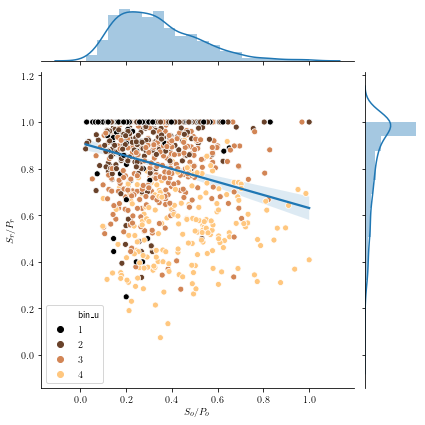

In [13]:
sns.jointplot(x, y, kind='reg', scatter=False)
ax = sns.scatterplot(x, y, hue=classes, palette="copper")
ax.set(xlabel=r"$S_o/P_o$", ylabel=r"$S_r/P_r$")
plt.savefig("../../results/sp_ratio_ratio_ubins_17rec_83org.pdf")

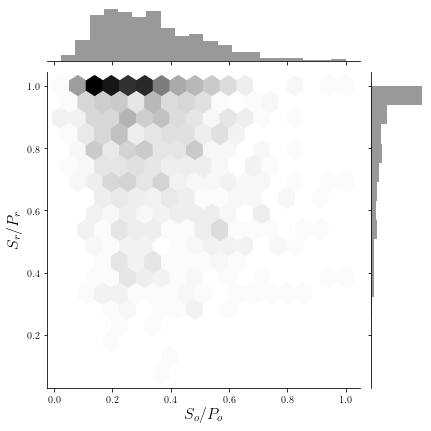

In [14]:
h = sns.jointplot(x, y, kind='hex', color="k")
h.set_axis_labels(r"$S_o/P_o$", r"$S_r/P_r$", fontsize=16)
plt.savefig("../../results/sp_ratio_ratio_hex.pdf")

In [16]:
ratio_data["quantile_org"] = pd.cut(ratio_data["ratio_org"], 5)
ratio_data["quantile_rec"] = pd.cut(ratio_data["ratio_rec"], 5)
ratio_means = ratio_data.groupby(["quantile_org", "bin_u"]).mean()["ratio_rec"].to_frame().reset_index().drop("quantile_org", axis=1)
ratio_means["ratio_org"] = np.repeat(np.arange(0.1, 1.0, 0.2), 4)

ratio_means_vert = ratio_data.groupby(["quantile_rec", "bin_u"]).mean()["ratio_org"].to_frame().reset_index().drop("quantile_rec", axis=1)
ratio_means_vert["ratio_rec"] = np.repeat(np.arange(0.1, 1.0, 0.2), 4)

ratio_means.columns = ["bin_u", "ratiorectot", "ratioorgtot"]
ratio_means_vert.columns = ["bin_u", "ratioorgvert", "ratiorecvert"]

ratio_data = ratio_data.append(ratio_means, ignore_index=True)
ratio_data = ratio_data.append(ratio_means_vert, ignore_index=True)
ratio_data

,user,ratio_org,rate,plays,bin_u,ratio_rec,quantile_org,quantile_rec,ratiorectot,ratioorgtot,ratioorgvert,ratiorecvert
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0.480815,5056.0,4,0.375527,"(0.219, 0.414]","(0.26, 0.445]",NaN,NaN,NaN,NaN
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0.208072,2874.0,3,0.531111,"(0.219, 0.414]","(0.445, 0.63]",NaN,NaN,NaN,NaN
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272516,0.012827,2105.0,1,0.400000,"(0.219, 0.414]","(0.26, 0.445]",NaN,NaN,NaN,NaN
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.386520,0.186013,2059.0,3,0.906149,"(0.219, 0.414]","(0.815, 1.0]",NaN,NaN,NaN,NaN
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512795,0.122784,1523.0,3,0.774436,"(0.414, 0.61]","(0.63, 0.815]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
976,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,0.464585,0.7
977,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0.241303,0.9
978,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,0.304635,0.9
979,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,0.365886,0.9


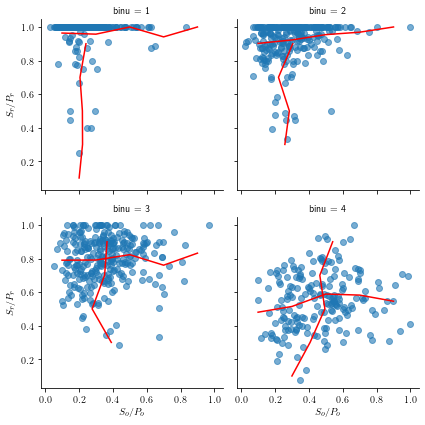

In [17]:
# Workaround to avoid LaTeX explosion
ratio_data.columns = ["user", "ratioorg", "rate", "plays", "binu", "ratiorec", "quantileorg", "quantilerec", "ratiorectot", "ratioorgtot", "ratioorgvert", "ratiorecvert"]

g = sns.FacetGrid(ratio_data, col="binu", col_wrap=2)
g.map(plt.scatter, "ratioorg", "ratiorec", alpha=0.6)
g.map(sns.lineplot, "ratioorgtot", "ratiorectot", color="r")
g.map(sns.lineplot, "ratioorgvert", "ratiorecvert", color="r", sort=False)
g.axes[2].set_xlabel("$S_o/P_o$")
g.axes[3].set_xlabel("$S_o/P_o$")
g.axes[2].set_ylabel("$S_r/P_r$")
g.axes[0].set_ylabel("$S_r/P_r$")
plt.savefig("../../results/sp_ratio_ratio_ubins_distinct.pdf")

# sns.lineplot(x="rate", y="ratio", data=sp_means, ax=h.ax_joint, color="r", markers=True)

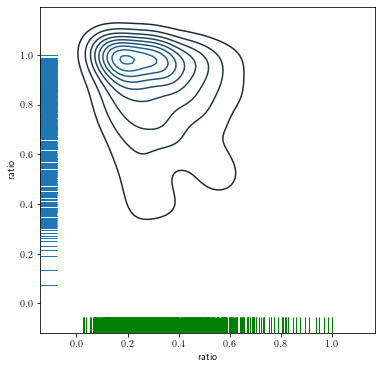

In [18]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x, y, ax=ax)
sns.rugplot(x, color="g", ax=ax)
sns.rugplot(y, vertical=True, ax=ax);

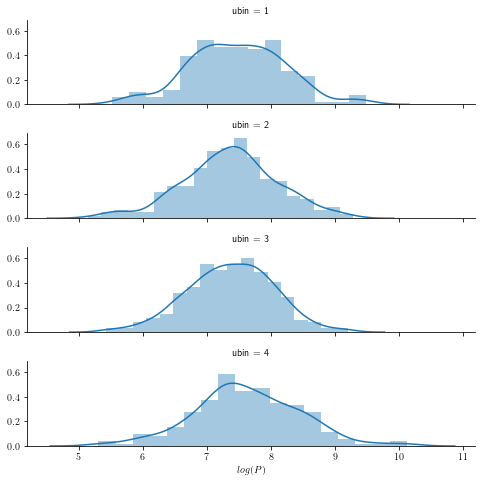

In [19]:
org_data["logplays"] = org_data["plays"].map(np.log)
g = sns.FacetGrid(org_data.rename(columns={"u_bin_nb": "ubin"}), row="ubin", height=1.7, aspect=4)
g.map(sns.distplot, "logplays")
g.axes[3, 0].set_xlabel("$log(P)$")
plt.savefig("../../results/pdist_ubins.png")

In [1]:
sns.catplot(x="binu", y="logplays", data=org_data.rename(columns={"u_bin_nb": "binu"}), kind="box")

NameError: name 'sns' is not defined

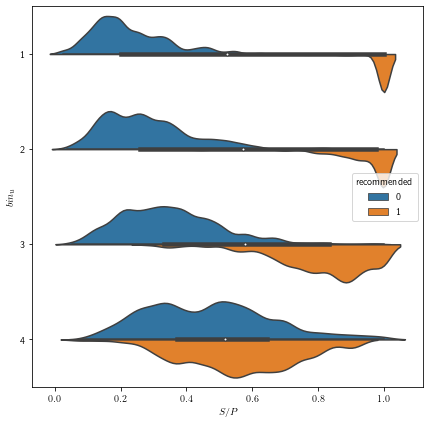

In [13]:
org_data["u_bin_nb"] = org_data["u_bin_nb"].astype('category')
f, ax = plt.subplots(figsize=(7, 7))
sns.violinplot(x="ratio", y="ubin", hue="recommended",  scale="count", scale_hue=True, data=org_data.rename(columns={"u_bin_nb": "ubin"}), split=True, bw=0.17, inner="box")
ax.set(ylabel="$bin_u$", xlabel="$S/P$")
plt.savefig("../../results/sp_ratio_violin_bin_u_pdist.png")

In [14]:
org_data["logplays"] = org_data["plays"].map(np.log)
org_data["quantile"] = pd.cut(org_data["ratio"], np.arange(0, 1.05, 0.05))
sp_list = org_data.groupby(["u_bin_nb", "recommended", "quantile"]).size().to_frame().reset_index()
sp_list["logplays"] = org_data.groupby(["u_bin_nb", "recommended", "quantile"])["logplays"].mean().to_frame().reset_index()["logplays"]
sp_list.to_csv("../../data/sp_data.csv", index=False)

In [15]:
# Getting total S/P ratio for each user
print("Computing diversity ratio...")
sp_data = get_songs_data(data, obs_threshold=0, separate_rec=False)

print("Organizing data...")
# get_songs_data produces a pd.Series, which we turn into a DataFrame before adjusting some column names
sp_data = sp_data.to_frame()
sp_data.index.names = ["user"]
sp_data.columns = ["ratio"]

sp_data = sp_data.merge(u_bins, on="user")
sp_data

Computing diversity ratio...
Organizing data...


,user,ratio,rate,plays,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259634,0.456532,4164,4
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.274580,0.179395,2514,3
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.273009,0.003861,1295,1
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.454339,0.173289,1812,3
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.510879,0.117953,1153,3
...,...,...,...,...,...
1008,fe22a3978a595c3a63cb40558db7804956f8e1d7,0.415179,0.017857,448,2
1009,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,0.399731,0.006729,743,1
1010,fea927761d221701b2bf1b6acc2de6d91d060071,0.080725,0.004255,2820,1
1011,ff7672529f1387bf35e1296f79009275287980a8,0.190534,0.004113,1702,1


NameError: name 'sp_means' is not defined

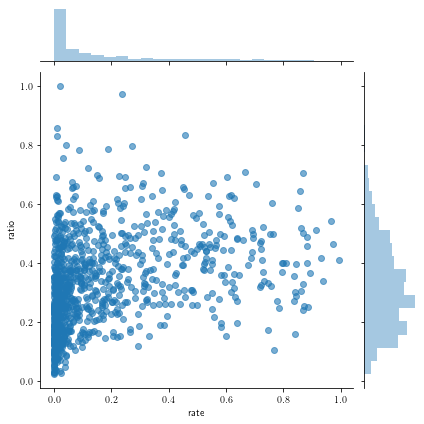

In [14]:
# f, ax = plt.subplots(figsize=(7, 7))
h = sns.jointplot(x="rate", y="ratio", data=sp_data, alpha=0.6)
sns.lineplot(x="rate", y="ratio", data=sp_means, ax=h.ax_joint, color="r", markers=True)
h.set_axis_labels(r'$\rho$', r'$S/P$', fontsize=16)
plt.savefig("../../results/sp_rho_scatter_meanbins.pdf")

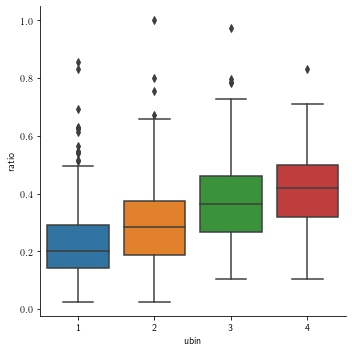

In [22]:
sns.catplot(x="ubin", y="ratio", data=sp_data.rename(columns={"u_bin_nb": "ubin"}), kind="box")
plt.savefig("../../results/sp_ubins.pdf")

In [51]:
sp_data["logplays"] = sp_data["plays"].map(np.log)
sp_data["quantile"] = pd.cut(sp_data["logplays"], np.arange(4.5, 10.5, 1))

plays_means = sp_data.groupby(["quantile"]).mean()["ratio"].to_frame().reset_index().drop("quantile", axis=1)
plays_means["logplays"] = np.arange(5, 10, 1)
plays_means

,user,ratio,rate,plays,u_bin_nb,logplays,quantile
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259634,0.456532,4164,4,8.334231,"(7.5, 8.5]"
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.274580,0.179395,2514,3,7.829630,"(7.5, 8.5]"
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.273009,0.003861,1295,1,7.166266,"(6.5, 7.5]"
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.454339,0.173289,1812,3,7.502186,"(7.5, 8.5]"
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.510879,0.117953,1153,3,7.050123,"(6.5, 7.5]"
...,...,...,...,...,...,...,...
1008,fe22a3978a595c3a63cb40558db7804956f8e1d7,0.415179,0.017857,448,2,6.104793,"(5.5, 6.5]"
1009,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,0.399731,0.006729,743,1,6.610696,"(6.5, 7.5]"
1010,fea927761d221701b2bf1b6acc2de6d91d060071,0.080725,0.004255,2820,1,7.944492,"(7.5, 8.5]"
1011,ff7672529f1387bf35e1296f79009275287980a8,0.190534,0.004113,1702,1,7.439559,"(6.5, 7.5]"


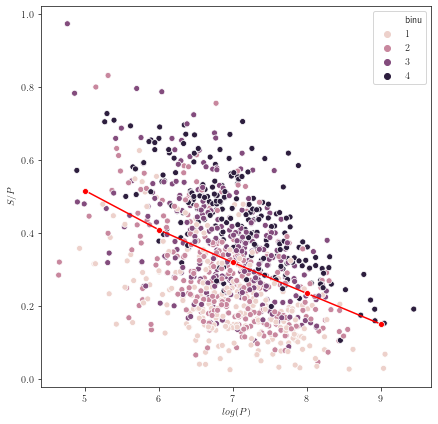

In [77]:
f, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(x="logplays", y="ratio", hue="binu", data=sp_data.rename(columns={"u_bin_nb": "binu"}))
sns.lineplot(x="logplays", y="ratio", data=plays_means, color="r", marker= "o")
ax.set(ylabel="$S/P$", xlabel="$log(P)$")
plt.savefig("../../results/sp_logp_bins.pdf")